content_based general approach: </br>
1. Make a one-hot vector for each record in the anime table, which means for each anime, this vector includes all kinds of genres and ways of broadcasting movies, and also it needs extra work to prepare the 'episodes' column in a suitable form. (Assume it'll have n column.)

2. Choose a user and find his taste based on his ratings to different movies:</br>

>>After finding all of the user's activity in the database in one-hot form (he saw m anime and each has n features: m*n vector), multiply the user's reaction/rating to each field/feature so we'll have:</br>
>>> **1*m vector * user's rating** </br>

>>For the next step, sum all these vectors accordingly, then finally, we have a profile of user interests.
This profile actually is a 1*n dimension vector.

3. Multiply user's profile vector to all anime and choose ten most ranked(those that achieve higher values).







In [ ]:
!pip install lightfm

     |████████████████████████████████| 310 kB 23.1 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705362 sha256=132f76cf15e336801b2c30bb88feb4652ee9269f33019f71e4d872e920171d28
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
anime_df = pd.read_csv('/content/drive/MyDrive/Information Retrival/finalProject/anime.csv')
rating_df = pd.read_csv('/content/drive/MyDrive/Information Retrival/finalProject/rating.csv')

##**anime dataframe preprocessing**

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
anime_df["name"] = anime_df['name'].str.replace('[^\w\s]',' ')

In [ ]:
anime_df['name'] = anime_df['name'].apply(lambda x: x.strip())

In [ ]:
print(len(anime_df))
anime_df.drop_duplicates(subset=['name'], keep='first', inplace=True)
print(len(anime_df))

12294
12268


split genres with use of ',' into separate peaces and put all of them into a list

In [ ]:
anime_df['genre'] = anime_df.genre.str.split(',')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic,...",TV,64,9.26,793665
2,28977,Gintama,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.25,114262
3,9253,Steins Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama 039,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.16,151266


### remove rows that contain null in genres and type

We need to find unique genres to create our one-hot vector unless we have duplicated features in one-hot, and it brings more complexity.

In [ ]:
anime_df["genre"].explode().unique()

array(['Drama', ' Romance', ' School', ' Supernatural', 'Action',
       ' Adventure', ' Drama', ' Fantasy', ' Magic', ' Military',
       ' Shounen', ' Comedy', ' Historical', ' Parody', ' Samurai',
       ' Sci-Fi', 'Sci-Fi', ' Thriller', 'Comedy', ' Sports',
       ' Super Power', ' Space', ' Slice of Life', ' Mecha', 'Adventure',
       ' Music', ' Mystery', ' Seinen', 'Fantasy', ' Martial Arts',
       ' Vampire', ' Shoujo', ' Horror', ' Police', ' Psychological',
       'Mystery', 'Psychological', ' Demons', 'Ecchi', ' Josei', 'Josei',
       'Military', 'Romance', ' Shounen Ai', ' Game', 'Demons', ' Ecchi',
       'Dementia', ' Harem', 'Music', 'Game', ' Cars', ' Dementia',
       'Cars', 'Mecha', 'Horror', 'School', ' Kids', 'Historical', 'Kids',
       ' Shoujo Ai', 'Shounen', 'Shoujo', 'Magic', 'Harem',
       'Martial Arts', 'Sports', 'Slice of Life', 'Seinen', nan, 'Parody',
       'Police', 'Thriller', 'Supernatural', 'Samurai', 'Super Power',
       'Vampire', 'Space', 'H

In [ ]:
anime_df[anime_df['genre'].isnull()]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS Infinite Stratos 2 Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike,NaN,TV,12,6.96,12345
6040,29765,Metropolis 2009,NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11070,32032,Seikaisuru Kado,NaN,NaN,Unknown,NaN,1797
11086,34310,Tamagotchi Movie Tanpen Himitsu no Otodoke Da...,NaN,Movie,1,NaN,51
11097,34474,Tsukipro The Animation,NaN,TV,Unknown,NaN,843
11112,33035,Yuyushiki Special,NaN,Special,1,NaN,2294


In [ ]:
print(len(anime_df))
anime_df = anime_df.dropna(subset=['genre'])
print(len(anime_df))

12268
12206


In [ ]:
anime_df['genre'] = [[val.strip() for val in sublist] for sublist in anime_df['genre'].values]
anime_df["genre"].explode().unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array(['Drama', 'Romance', 'School', 'Supernatural', 'Action',
       'Adventure', 'Fantasy', 'Magic', 'Military', 'Shounen', 'Comedy',
       'Historical', 'Parody', 'Samurai', 'Sci-Fi', 'Thriller', 'Sports',
       'Super Power', 'Space', 'Slice of Life', 'Mecha', 'Music',
       'Mystery', 'Seinen', 'Martial Arts', 'Vampire', 'Shoujo', 'Horror',
       'Police', 'Psychological', 'Demons', 'Ecchi', 'Josei',
       'Shounen Ai', 'Game', 'Dementia', 'Harem', 'Cars', 'Kids',
       'Shoujo Ai', 'Hentai', 'Yaoi', 'Yuri'], dtype=object)

To find episodes in the next step, we have to remove null values in the 'type' field in order to calculate mean of episodes of each type.

In [ ]:
print(anime_df["type"].unique())
anime_df = anime_df.dropna(subset=['type'])
print(anime_df["type"].unique())

['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA' nan]
['Movie' 'TV' 'OVA' 'Special' 'Music' 'ONA']


###**some preprocess on episodes:**

In order to have a continuous range of episodes in a one-hot vector, we need to split it into several ranges; I used box_plot to find breakpoints.

- change 'Unknown' values to np.NaN.
- change type of 'episodes' column to int( to calculate min, max, and mean)

In [ ]:
anime_df.loc[anime_df['episodes'] == 'Unknown','episodes'] = np.nan
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes     object
rating      float64
members       int64
dtype: object

In [ ]:
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'])
anime_df.dtypes

anime_id      int64
name         object
genre        object
type         object
episodes    float64
rating      float64
members       int64
dtype: object

In [ ]:
print(anime_df['episodes'].min(), anime_df['episodes'].max())

1.0 1818.0


In [ ]:
anime_df['episodes'] = anime_df.groupby(by='type')['episodes'].transform(lambda x: x.fillna(x.mean()))
anime_df[anime_df['episodes'].isna()]

,anime_id,name,genre,type,episodes,rating,members


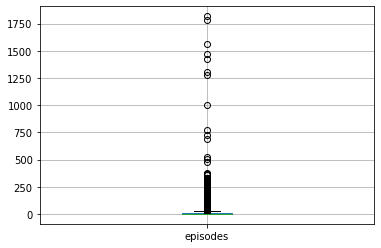

In [ ]:
anime_df.boxplot(column=['episodes'])

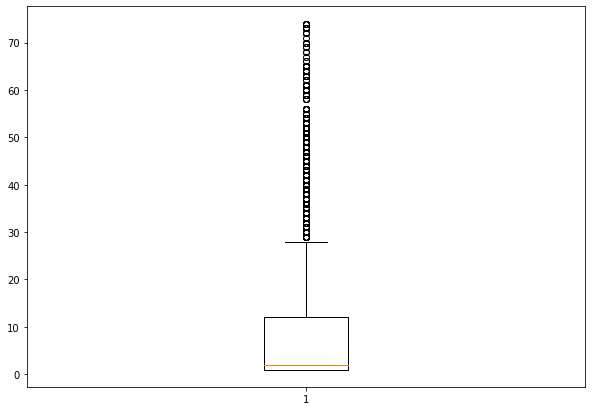

In [ ]:
specific_episodes = anime_df.loc[anime_df['episodes']<75, ['episodes']]

fig = plt.figure(figsize =(10, 7))
plt.boxplot(specific_episodes['episodes'])
plt.show()

it seems that [0:1] , [2:12], [12:28], and [29:] ranges are reasonable ones to split the episodes range.

###**create the one-hot table**

In [ ]:
anime_separatedGenres_df = anime_df.copy()

for index, row in anime_separatedGenres_df.iterrows():
  anime_separatedGenres_df.at[index, row['type']] = 1
  for genre in row['genre']:
      anime_separatedGenres_df.at[index, genre] = 1
  if row['episodes'] < 2: anime_separatedGenres_df.at[index, 'episode1'] = 1
  elif row['episodes'] < 13: anime_separatedGenres_df.at[index, 'episode2'] = 1
  elif row['episodes'] < 28: anime_separatedGenres_df.at[index, 'episode3'] = 1
  else: anime_separatedGenres_df.at[index, 'episode4'] = 1


anime_separatedGenres_df = anime_separatedGenres_df.fillna(0)
anime_separatedGenres_df.head(20)

,anime_id,name,genre,type,episodes,rating,members,Movie,Drama,Romance,School,Supernatural,episode1,TV,Action,Adventure,Fantasy,Magic,Military,Shounen,episode4,Comedy,Historical,Parody,Samurai,Sci-Fi,Thriller,episode3,Sports,episode2,Super Power,OVA,Space,Slice of Life,Mecha,Music,Mystery,Seinen,Martial Arts,Vampire,Shoujo,Horror,Police,Psychological,Special,Demons,Ecchi,Josei,Shounen Ai,Game,Dementia,Harem,Cars,ONA,Kids,Shoujo Ai,Hentai,Yaoi,Yuri
0,32281,Kimi no Na wa,"[Drama, Romance, School, Supernatural]",Movie,1.0,9.37,200630,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114,Fullmetal Alchemist Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28977,Gintama,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.25,114262,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9253,Steins Gate,"[Sci-Fi, Thriller]",TV,24.0,9.17,673572,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9969,Gintama 039,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51.0,9.16,151266,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,32935,Haikyuu Karasuno Koukou VS Shiratorizawa Ga...,"[Comedy, Drama, School, Shounen, Sports]",TV,10.0,9.15,93351,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,11061,Hunter x Hunter 2011,"[Action, Adventure, Shounen, Super Power]",TV,148.0,9.13,425855,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,820,Ginga Eiyuu Densetsu,"[Drama, Military, Sci-Fi, Space]",OVA,110.0,9.11,80679,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,15335,Gintama Movie Kanketsu hen Yorozuya yo Eien...,"[Action, Comedy, Historical, Parody, Samurai, ...",Movie,1.0,9.10,72534,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,15417,Gintama 039 Enchousen,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,13.0,9.11,81109,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##**rating dataframe preprocessing**

In [ ]:
print(max(rating_df['rating']))
print(min(rating_df['rating']))

10
-1


Having a score of **-1** is not pleasant so remove it by adding one to all records.

In [ ]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: x+1)
print(max(rating_df['rating']))
print(min(rating_df['rating']))
rating_df

11
0


,user_id,anime_id,rating
0,1,20,0
1,1,24,0
2,1,79,0
3,1,226,0
4,1,241,0
...,...,...,...
7813732,73515,16512,8
7813733,73515,17187,10
7813734,73515,22145,11
7813735,73516,790,10


##**now find the user's profile/prefrences**

First, choose a specific user by its id. Then, find the table representing the one-hot form of the movies that the user saw and rated them.

In [ ]:
r1 = random.randint(1, rating_df['user_id'].max())
particular_user = rating_df[rating_df.user_id==r1]
particular_user

,user_id,anime_id,rating
6720332,62056,226,11
6720333,62056,2001,11
6720334,62056,2167,10
6720335,62056,4181,11
6720336,62056,5114,11
6720337,62056,6547,10
6720338,62056,10620,9
6720339,62056,11617,6
6720340,62056,11757,10
6720341,62056,15451,6


In [ ]:
userAnime = anime_separatedGenres_df[anime_separatedGenres_df['anime_id'].isin(particular_user['anime_id'].tolist())]
userAnime

,anime_id,name,genre,type,episodes,rating,members,Movie,Drama,Romance,School,Supernatural,episode1,TV,Action,Adventure,Fantasy,Magic,Military,Shounen,episode4,Comedy,Historical,Parody,Samurai,Sci-Fi,Thriller,episode3,Sports,episode2,Super Power,OVA,Space,Slice of Life,Mecha,Music,Mystery,Seinen,Martial Arts,Vampire,Shoujo,Horror,Police,Psychological,Special,Demons,Ecchi,Josei,Shounen Ai,Game,Dementia,Harem,Cars,ONA,Kids,Shoujo Ai,Hentai,Yaoi,Yuri
1,5114,Fullmetal Alchemist Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64.0,9.26,793665,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,4181,Clannad After Story,"[Drama, Fantasy, Romance, Slice of Life, Super...",TV,24.0,9.06,456749,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,2001,Tengen Toppa Gurren Lagann,"[Action, Adventure, Comedy, Mecha, Sci-Fi]",TV,27.0,8.78,562962,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,16498,Shingeki no Kyojin,"[Action, Drama, Fantasy, Shounen, Super Power]",TV,25.0,8.54,896229,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,19815,No Game No Life,"[Adventure, Comedy, Ecchi, Fantasy, Game, Supe...",TV,12.0,8.47,602291,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
159,6547,Angel Beats,"[Action, Comedy, Drama, School, Supernatural]",TV,13.0,8.39,717796,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,2167,Clannad,"[Comedy, Drama, Romance, School, Slice of Life...",TV,23.0,8.30,566690,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,18679,Kill la Kill,"[Action, Comedy, School, Super Power]",TV,24.0,8.23,508118,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
445,10620,Mirai Nikki TV,"[Action, Mystery, Psychological, Shounen, Supe...",TV,26.0,8.07,657190,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
724,15451,High School DxD New,"[Action, Comedy, Demons, Ecchi, Harem, Romance...",TV,12.0,7.87,266657,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Resetting the index to avoid future issues
userAnime = userAnime.reset_index(drop=True)

#Dropping unnecessary issues due to easier multiplication
userGenre = userAnime.drop('anime_id', 1).drop('name', 1).drop('genre', 1).drop('type', 1).drop('episodes', 1).drop('members', 1).drop('rating', 1)
userGenre

,Movie,Drama,Romance,School,Supernatural,episode1,TV,Action,Adventure,Fantasy,Magic,Military,Shounen,episode4,Comedy,Historical,Parody,Samurai,Sci-Fi,Thriller,episode3,Sports,episode2,Super Power,OVA,Space,Slice of Life,Mecha,Music,Mystery,Seinen,Martial Arts,Vampire,Shoujo,Horror,Police,Psychological,Special,Demons,Ecchi,Josei,Shounen Ai,Game,Dementia,Harem,Cars,ONA,Kids,Shoujo Ai,Hentai,Yaoi,Yuri
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only consider movies that remained in the anime_df dataframe, records didn't have np.NaN values.

In [ ]:
particular_user = particular_user.loc[particular_user['anime_id'].isin(userAnime['anime_id'])]
particular_user = particular_user.reset_index(drop=True)

In [ ]:
particular_user['rating']

0     11
1     11
2     10
3     11
4     11
5     10
6      9
7      6
8     10
9      6
10     9
11     9
12     8
13     9
Name: rating, dtype: int64

Multiply each anime's one-hot vector to its rating in order to have weighted vectors and sum altogether.

In [ ]:
userProfile = userGenre.transpose().dot(particular_user['rating'])
userProfile

Movie              0.0
Drama             61.0
Romance           52.0
School            40.0
Supernatural      60.0
episode1           0.0
TV               130.0
Action            90.0
Adventure         49.0
Fantasy           61.0
Magic             11.0
Military          11.0
Shounen           32.0
episode4          11.0
Comedy            61.0
Historical         0.0
Parody             0.0
Samurai            0.0
Sci-Fi            10.0
Thriller          10.0
episode3          93.0
Sports             0.0
episode2          26.0
Super Power       17.0
OVA                0.0
Space              0.0
Slice of Life     20.0
Mecha             10.0
Music              0.0
Mystery           10.0
Seinen             9.0
Martial Arts       0.0
Vampire            0.0
Shoujo             0.0
Horror             9.0
Police             0.0
Psychological     19.0
Special            0.0
Demons            15.0
Ecchi             26.0
Josei              0.0
Shounen Ai         0.0
Game              19.0
Dementia   

Do some work on anime_table to make it like the user's profile layout to multiply these two in the easiest way.

In [ ]:
genreTable = anime_separatedGenres_df.set_index(anime_separatedGenres_df['anime_id'])
#And drop the unnecessary information
genreTable = genreTable.drop('anime_id', 1).drop('name', 1).drop('genre', 1).drop('type', 1).drop('episodes', 1).drop('members', 1).drop('rating', 1)
genreTable.head()

,Movie,Drama,Romance,School,Supernatural,episode1,TV,Action,Adventure,Fantasy,Magic,Military,Shounen,episode4,Comedy,Historical,Parody,Samurai,Sci-Fi,Thriller,episode3,Sports,episode2,Super Power,OVA,Space,Slice of Life,Mecha,Music,Mystery,Seinen,Martial Arts,Vampire,Shoujo,Horror,Police,Psychological,Special,Demons,Ecchi,Josei,Shounen Ai,Game,Dementia,Harem,Cars,ONA,Kids,Shoujo Ai,Hentai,Yaoi,Yuri
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5114,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28977,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9253,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9969,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

anime_id
32281    0.218014
5114     0.466735
28977    0.341863
9253     0.248721
9969     0.341863
dtype: float64

Remove duplicated movies that have actually seen before.

In [ ]:
unseen_recommendation_df = recommendationTable_df[~recommendationTable_df.isin(particular_user['anime_id'])]
unseen_recommendation_df

anime_id
32281    0.218014
5114     0.466735
28977    0.341863
9253     0.248721
9969     0.341863
           ...   
9316     0.000000
5543     0.000000
5621     0.026612
6133     0.000000
26081    0.000000
Length: 12184, dtype: float64

In [ ]:
unseen_recommendation_df = unseen_recommendation_df.sort_values(ascending=False)
unseen_recommendation_df.head(20)

anime_id
231      0.702149
6811     0.669396
33       0.655067
969      0.653019
1195     0.642784
98       0.623337
998      0.620266
25157    0.618219
573      0.617195
157      0.612078
1546     0.612078
1224     0.607984
3655     0.601842
355      0.600819
2787     0.600819
177      0.591607
1517     0.591607
1136     0.587513
32379    0.586489
249      0.585466
dtype: float64

**FINALLY... TOP TEN**

In [ ]:
topTen_df = anime_df.loc[anime_df['anime_id'].isin(unseen_recommendation_df.head(10).keys())]
topTen_df

,anime_id,name,genre,type,episodes,rating,members
151,33,Berserk,"[Action, Adventure, Demons, Drama, Fantasy, Ho...",TV,25.0,8.40,226430
173,6811,InuYasha Kanketsu hen,"[Action, Adventure, Comedy, Demons, Fantasy, M...",TV,26.0,8.37,99128
1071,969,Tsubasa Chronicle 2nd Season,"[Action, Adventure, Drama, Fantasy, Mystery, R...",TV,26.0,7.70,79166
1246,1195,Zero no Tsukaima,"[Action, Adventure, Comedy, Ecchi, Fantasy, Ha...",TV,13.0,7.62,346828
1315,98,Mai HiME,"[Action, Comedy, Drama, Fantasy, Magic, Mecha,...",TV,26.0,7.59,76492
1762,573,Saber Marionette J,"[Action, Adventure, Comedy, Drama, Harem, Mart...",TV,25.0,7.45,17561
1845,25157,Trinity Seven,"[Action, Comedy, Ecchi, Fantasy, Harem, Magic,...",TV,12.0,7.43,208796
2903,998,Blue Seed,"[Action, Adventure, Comedy, Demons, Drama, Ecc...",TV,26.0,7.13,15194
2992,157,Mahou Sensei Negima,"[Comedy, Ecchi, Fantasy, Harem, Magic, Romance...",TV,26.0,7.11,76253
5917,231,Asagiri no Miko,"[Action, Comedy, Drama, Fantasy, Magic, School...",TV,26.0,6.31,4721


##**Evaluation**

We need to have both vectors in the same dimension to multiply them and find mean square error.

In [ ]:
topTen_oneHot_df = anime_separatedGenres_df\
[anime_separatedGenres_df['anime_id'].isin(unseen_recommendation_df.head(10).keys())]
topTen_oneHot_df = topTen_oneHot_df.drop('anime_id', 1).drop('name', 1).drop('genre', 1).drop('type', 1).drop('episodes', 1).drop('members', 1).drop('rating', 1)
topTen_oneHot_df

,Movie,Drama,Romance,School,Supernatural,episode1,TV,Action,Adventure,Fantasy,Magic,Military,Shounen,episode4,Comedy,Historical,Parody,Samurai,Sci-Fi,Thriller,episode3,Sports,episode2,Super Power,OVA,Space,Slice of Life,Mecha,Music,Mystery,Seinen,Martial Arts,Vampire,Shoujo,Horror,Police,Psychological,Special,Demons,Ecchi,Josei,Shounen Ai,Game,Dementia,Harem,Cars,ONA,Kids,Shoujo Ai,Hentai,Yaoi,Yuri
151,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1071,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1246,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1315,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1762,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1845,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2903,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2992,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5917,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

final_error = 0
for rec_movie in topTen_oneHot_df.values.tolist():
  m_rmse = 0
  for u_movie in userGenre.values.tolist():
    rmse = sqrt(mean_squared_error(u_movie, rec_movie))
    if rmse > m_rmse: m_rmse = rmse
  final_error = final_error + m_rmse
print(final_error/10)

0.5053642826021787
